In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from datetime import timedelta
from dotenv import find_dotenv
from os.path import dirname
from os.path import exists
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.load import load_train_df
from src.load import load_test_df
from src.transform import get_week_by_dept_df
from src.transform import unpivot_week_by_dept_df
from src.features import make_id_column

# Root directory of repo
project_dir = dirname(find_dotenv())

# Use custom matplotlib style
plt.style.use(join(project_dir, 'big-darkgrid.mplstyle'))

# Baseline Models

Let's look at some simple ways we could model this problem to get a baseline to build from. One way to get pretty far with seasonal data like this is to look at past values and either pick the most recent value from that date or average all the data from past matching dates.

In [3]:
week_by_dept_df = get_week_by_dept_df()
week_by_dept_df.head()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,40212.84,48027.87,36705.57,10365.86,74020.63,55033.94,25694.43,36872.18,8912.27,4046.34,...,7245.32,2335.92,292.64,11620.09,7.58,982.500000,23292.10,2438.08,668.48,1.5
2010-02-12,67699.32,50595.72,31052.34,9375.25,69145.42,51167.46,24555.89,34782.91,28176.35,3602.73,...,6556.94,2486.18,544.74,11080.50,7.58,982.500000,22317.38,2304.09,766.93,1.5
2010-02-19,49748.33,51199.72,33224.65,11032.90,68060.96,49011.24,33321.92,34512.54,16244.14,3617.85,...,7301.19,2452.70,424.26,10233.49,7.58,2163.750000,20694.32,1944.11,607.02,1.5
2010-02-26,33601.22,50028.83,29268.91,11058.90,71517.99,49829.71,27773.67,31175.51,916.25,4207.51,...,7814.18,2386.49,470.43,10786.42,7.58,2059.545455,21780.08,2423.55,580.74,1.5
2010-03-05,36572.44,49892.15,31934.99,11033.07,70279.43,46865.98,35227.56,33143.03,1426.47,3623.52,...,10540.89,2369.01,679.47,11176.21,7.58,1955.340909,22187.57,2591.28,371.05,1.5


The dates don't line up perfectly year-by-year, so let's see if just shifting by 52 rows works. 

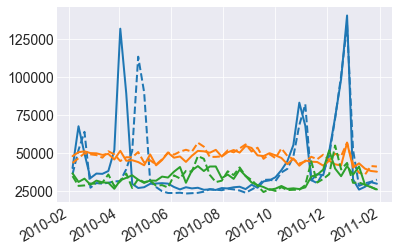

In [4]:
index = week_by_dept_df.index[:52]
for i in range(3):
    l, = plt.plot(index, week_by_dept_df.iloc[:52, i])
    plt.plot(index, week_by_dept_df.iloc[52:104, i], '--', color=l.get_color())
plt.gcf().autofmt_xdate()
plt.show()

The solid lines below are for the year starting in Feb. 2010, and the dashed lines are for the corresponding dates from the next 52 rows. Christmas and Halloween line up well, and Easter doesn't but that's because it was the 4th in 2010 and the 24th in 2011. So this looks good.

Before making a baseline, let's set up our evaluation function as described [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting#evaluation).

In [5]:
def wmae(y_pred, y_actual, is_holiday=None, holiday_weight=5):
    if is_holiday is None:
        test_df = load_test_df()
        is_holiday = test_df['IsHoliday']
    n = len(y_pred)
    assert(n == len(y_actual))
    assert(n == len(is_holiday))
    weights = np.ones(n)
    weights[is_holiday] = holiday_weight
    return 1.0 / np.sum(weights) * np.sum(weights * np.abs(y_actual - y_pred))

In [6]:
class PrevYearBaseline():
    def __init__(self, fillna_method='interpolate'):
        self.fillna_method = fillna_method
    
    def fit(self, X):
        """Given X with columns 'Store', 'Dept', 'Date', and 'Weekly_Sales',
        save data to be accessed by predict
        """
        self.week_by_dept = get_week_by_dept_df(X, fillna_method=self.fillna_method)
    
    def predict(self, X, return_pivoted=False):
        """Given X with columns 'Store', 'Dept', and 'Date', predict 'Weekly_Sales'
        """
        X = make_id_column(X)
        pred_week_by_dept = get_week_by_dept_df(X, fillna_method=None, values=None)
        for c in pred_week_by_dept.columns:
            if c not in self.week_by_dept.columns:
                self.week_by_dept[c] = self.week_by_dept.mean(axis=1)
        
        copy_week_by_dept = self.week_by_dept[pred_week_by_dept.columns.tolist()].copy()
        copy_week_by_dept.index += timedelta(weeks=52)
        pred_week_by_dept = copy_week_by_dept.loc[pred_week_by_dept.index]
        if return_pivoted:
            return pred_week_by_dept
        else:
            unpivoted = unpivot_week_by_dept_df(pred_week_by_dept)
            unpivoted = make_id_column(unpivoted)
            unpivoted = unpivoted.set_index('Id', drop=True)
            unpivoted = unpivoted.reindex(X['Id'])
            return unpivoted['Weekly_Sales']

In [7]:
full_train_df = load_train_df()
split_date = full_train_df['Date'].min() + timedelta(weeks=104)
train_df = full_train_df[full_train_df['Date']<split_date]
test_df = full_train_df[full_train_df['Date']>=split_date]
test_df = make_id_column(test_df).set_index('Id', drop=True)
test_df, y_actual = test_df[['Store', 'Dept', 'Date', 'IsHoliday']], test_df['Weekly_Sales']

In [8]:
bl = PrevYearBaseline()
bl.fit(train_df)
y_pred = bl.predict(test_df)

Error on holdout set on last 39 weeks of data trained on 2 years of data:

In [9]:
wmae(y_pred, y_actual, test_df['IsHoliday'])

1811.0863308312692

# Check score on Kaggle

In [10]:
bl = PrevYearBaseline()
test_df = load_test_df()
bl.fit(full_train_df)
y_pred = bl.predict(test_df)

In [11]:
file_path = join(project_dir, 'data/processed/baseline_kaggle_sub.csv')
if not exists(file_path):
    y_pred.to_csv(file_path, index=True, header=True)

This submission from just looking at last year's value gave a score of 2951, which would put me in position 181 out of 691.